# Training Models

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Linear Regression

Model: $h_{\mathbf{\theta}}(\mathbf{x}) = \hat{y} = \theta^T \mathbf{x}$

In [2]:
np.random.seed(42)

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

### Normal Equation
$\mathbf{\hat{\theta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$

In [3]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.21509616],
       [2.77011339]])

Try some prediction

In [4]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

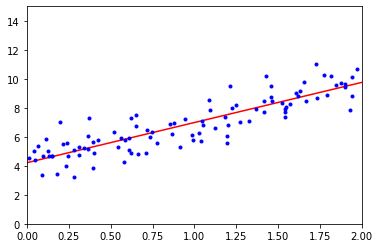

In [5]:
plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.show()

Now using *Scikit-Learn*

In [6]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [7]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

`LinearRegression` uses Least Squares modeule `lstsq` from `scipy`

In [8]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

Compared to the normal equation, this uses a pseudo-inverse for cases $(\mathbf{X}^T \mathbf{X})^{-1}$ doesn't exist (e.g. $\mathbf{X}$ is under-specified: $m < n$).

The equation then is $\mathbf{\hat{\theta}} = \mathbf{X}^{+} \mathbf{y}$ where $\mathbf{X}^{+}$ is the *pseudo-inverse* found e.g. by SVD as $\mathbf{X}^{+} = \mathbf{U} \mathbf{\Sigma}^{+} \mathbf{V}$. $\mathbf{\Sigma}^{+}$ is extracted from standard $\mathbf{\Sigma}$ from SVD but with all values less then some $\epsilon$ replaced by zero, then replacing all non-zeros by their inverses and finally transposing the matrix.

Also, using SVD results in $\mathcal{O}(n^2)$ whereas normal equation is $\mathcal{O}(n^{2.4})$ to $\mathcal{O}(n^{3})$ depending on implementation.

In [9]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

## Gradient Descend
The algorithm is as follows:
1. Initialize $\mathbf{\theta}^0$ to some random values.
1. Iterate $\mathbf{\theta}^{t+1} = \mathbf{\theta}^t - \eta \nabla J(\mathbf{\theta}^t)$ where $J$ is the MSE (MSE yields the same optimum as RMES and is easier to optimize).
$\eta$ here is the *learning rate*.

One can stop the iteration for instance when the norm of the gradient is smaller than some $\epsilon$. Note that is is very useful to normalize the inputs.

### Batch GD
Batch GD updates model parameters ($\mathbf{\theta}$) based on gradient computed from the **full** training set ($\mathbf{X}$). In case of linear model, the MSE error gradient is the following: $\nabla MSE(\mathbf{\theta}) = \frac{2}{m} \mathbf{X}^T (\mathbf{X} \mathbf{\theta} - \mathbf{y})$

In [10]:
np.random.seed(42)

eta = 0.1
num_iters = 1000
m = 100

theta = np.random.randn(2, 1)

for it in range(num_iters):
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    
theta

array([[4.21509616],
       [2.77011339]])

### Stochastic Gradient Descent

Compared to batch GD where we computed gradients using whole training set, here we randomly sample one example at a time. It is important to select there randomly as SGD converges only under the IID assumption.

Furthermore, it is common to use a *Simulated Annealing* cooling schedule to adapt the learning rate.

Finally, micro-batch SGD uses a sample of more then single training example (but not full $\mathbf{X}$) to compute the gradient.

In [11]:
np.random.seed(42)

num_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(num_epochs):
    for i in range(m):
        rand_ix = np.random.randint(m)
        xi = X_b[rand_ix:rand_ix+1]
        yi = y[rand_ix:rand_ix+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

theta

array([[4.21076011],
       [2.74856079]])

Now using SGD with *Scikit-Learn* where
* `tol` is the allowed distance from optimum ($\epsilon$ discussed above)
* `penalty` is used for additional regularization
* `eta0` is the initial learning rate

In [12]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([4.23868557]), array([2.82181634]))

## Polynomial Regression

The idea here is that to fit non-linear data we can add non-linear transformations of input features as new features. For instance for an input features $x$ we add $x^2$. Linear combination of parameters and such features then creates a polynomial model.

`PolynomialFeatures` from *Scikit-Learn* then for given degree adds all combinations of input features up to that degree (beware of combinatorial explosion).

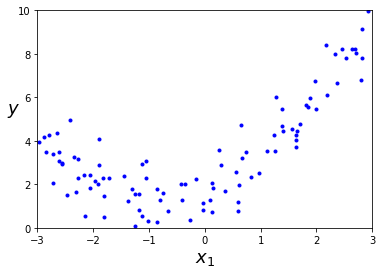

In [13]:
np.random.seed(42)

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.plot(X, y, 'b.')
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [14]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([-0.75275929]), array([-0.75275929,  0.56664654]))

In [15]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

## Learning Curves
Graph of training (validation) error against varying train set size (i.e. the number of examples the model has seen) is another way how to tell whether the model is over/under-fit.

### Bias/Variance tradeoff
Generally the overall generalization error of any model is composed of three parts:
* **Bias** - due to wrong assumptions (e.g. using linear model for non-linear, e.g. quadratic, data)
* **Variance** - due to model's sensitivity to small changes in the training data (e.g. high-degree polynomial overfitting the data)
* **Irreducible error** - due to noisiness in the data itself (e.g. dirty data, system errors, outliers)

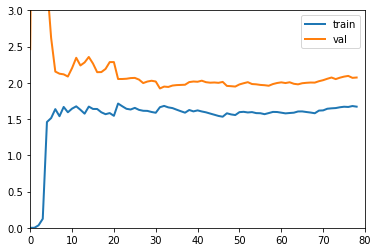

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors), linewidth=2, label='val')
    plt.legend()
    
lin_reg = LinearRegression()

plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

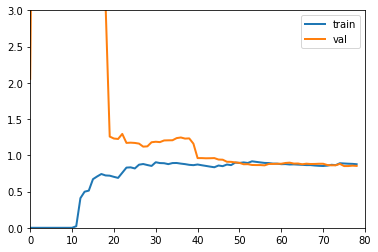

In [17]:
from sklearn.pipeline import Pipeline

poly_reg = Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_reg', LinearRegression()),
])

plot_learning_curves(poly_reg, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

## Regularized Linear Models
Generally used to limit the degrees of freedom of a model in order to prevent ovefitting and help generalization.

In [18]:
np.random.seed(42)

m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

### Ridge Regression
Ridge regression restricts the magnitude of model parameters by adding a penalty equal to half of $\ell_2$ norm of the model weights.
The cost function for MSE is then $J(\mathbf{\theta}) = MSE(\mathbf{\theta}) + \alpha \frac{1}{2} \sum_{i = 1}^n \theta_i^2$.

In [19]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

Using SGD it looks like this...

In [20]:
sgd_reg = SGDRegressor(penalty='l2')
sgd_reg.fit(X, y)
sgd_reg.predict([[1.5]])

array([1.46543286])

### Lasso Regression
Lasso regression is basically the same as *Ridge Regression* but it penalizes parameters based on their $\ell_1$ norm. It is interesting because as a side-effect it performs feature selection since the weights of the least relevant features will be forced to 0. The cost function for MSE is $J(\mathbf{\theta}) = MSE(\mathbf{\theta}) + \alpha \sum_{i = 1}^n |\theta_i|$.

In [21]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

### Elastic Net
Elastic Net is an affine combination of *Ridge* and *Lasso* regressions with mixture hyper-parameter $r$. The cost funciton for MSE looks as follows: $J(\mathbf{\theta}) = MSE(\mathbf{\theta}) + r LASSO(\mathbf{\theta}) + (1 - r)RIDGE(\mathbf{\theta})$.

In [22]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

## Early Stopping
Another way how to regularize a liearning algorithm is to look at the learning curves and stop the learning as soon as the validation error reaches its minimum. It might be difficult to determine whether an algorithm has already reached a minimum. A common strategy is to keep learning for a while and if the error doesn't improve then go back to the minimum.

In [23]:
np.random.seed(42)

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [24]:
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# prepare the data
poly_scaler = Pipeline([
    ('poly_features', PolynomialFeatures(degree=90, include_bias=False)),
    ('std_scaler', StandardScaler()),
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None, learning_rate='constant', eta0=0.0005)

min_val_error = float('inf')
best_epoch = None
best_model = None

for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < min_val_error:
        min_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)
        
print(best_epoch, best_model)

243 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
             tol=-inf, warm_start=True)


## Logistic Regression

The model for logistic regression is a linear (affine) function passed through a logistic function (sigmoid): $h_{\mathbf{\theta}}(\mathbf{x}) = \hat{p} = \sigma(\mathbf{\theta}^T \mathbf{x})$ where $\hat{p}$ is the probability of the input instance belonging to the *positive* class. The prediction is then simply done as $\hat{y} = sign(\hat{p})$.

The logistic function is defined as $\sigma(z) = \frac{1}{1 + e^{-z}}$.

Cost function is the *log loss* and is defined as $J(\mathbf{\theta}) = -\frac{1}{m}\sum_{i=1}^{m}[y^{(i)}\log(\hat{p}^{(i)}) + (1 - y^{(i)})\log(1 - \hat{p}^{(i)})]$

There's no closed-form equation for computing the optimum of the log loss function. However, it's a convex function so any local optimization can find the global minimum (e.g. gradient descent).

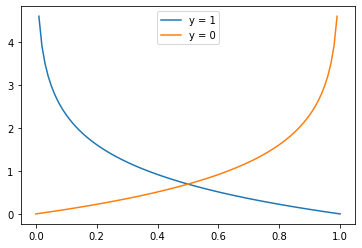

In [25]:
p = np.linspace(0, 1, 100)
plt.plot(p, -np.log(p), label='y = 1')
plt.plot(p, -np.log(1 - p), label='y = 0')
plt.legend()
plt.show()